In [7]:
import numpy as np
import matplotlib.pyplot as plt #matplob lib
%matplotlib inline
import os

import astropy.io.ascii as at
from scipy.interpolate import griddata, LinearNDInterpolator, interp2d
import numpyro
import numpyro.distributions as dist
from jax import random
import jax.numpy as jnp

In [2]:
# read in our MIST isochrone
data = at.read("MIST_iso_67e56fd8ac521.iso.cmd")

# filter out AGB/RGB stars so we're left with just main sequence stars
ms = (data['EEP'] < 605) & (data['log_g'] > 2.0)
data = data[ms]

# sanity print mins and maxs of logg and teff
(min(data['log_g']), max(data['log_g']),
10**min(data['log_Teff']), 10**max(data['log_Teff']))

(np.float64(2.016473965578847),
 np.float64(5.219173330672141),
 np.float64(2852.90475694454),
 np.float64(6611.359927800581))

In [3]:
out = {}

out['iso'] = data['log_Teff', 'log_g', 'initial_mass']

# out['iso'] = 10**data['log_Teff'], data['log_g'], data['initial_mass']

out['iso']['Teff'] = 10**out['iso']['log_Teff']
del(out['iso']['log_Teff'])

out['iso']

log_g,initial_mass,Teff
float64,float64,float64
5.219173330672141,0.10331965605076723,2852.90475694454
5.210097400095176,0.10722995675658707,2871.426772679346
5.125557731436499,0.14551443880232373,3043.250270866061
5.113599158725646,0.15196215136678998,3065.8589579837094
5.101390956760364,0.15863977245194313,3088.979471101631
5.089240988406002,0.1668724021671966,3110.692582312181
5.073608290086558,0.17982274249296165,3135.6645730593646
5.058022948354067,0.19279845940840507,3160.754584925618
5.042676309900792,0.20552708463359626,3185.587810805356


In [299]:
# define and sample priors for teff and log(g)
# this is purely for this notebook and should not be implemented into uberMS
teff_prior = dist.Uniform(low=min(10**data['log_Teff']), high=max(10**data['log_Teff']))
sample_Teff_a = teff_prior.sample(random.PRNGKey(2))


logga_prior = dist.Uniform(low=min(data['log_g']), high=max(data['log_g']))
sample_logg_a = logga_prior.sample(random.PRNGKey(2))

q_prior = dist.Uniform(low=1E-6, high=1.0)
sample_q = q_prior.sample(random.PRNGKey(2))

(sample_Teff_a, sample_logg_a, sample_q)

(Array(5261.289, dtype=float32),
 Array(4.068735, dtype=float32),
 Array(0.6407914, dtype=float32))

In [ ]:
# print the sample we took
print(sample_Teff_a, sample_logg_a, sample_q)

# define a tolerance to find the closest teff and logg
teff_tol = 100
logg_tol = 1


# define a condition to find the indices of the closest teff and logg
cond_teff = jnp.abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol
cond_logg = jnp.abs(data['log_g'] - sample_logg_a) < logg_tol


idx_closest = jnp.where(cond_teff & cond_logg)
closest_logg = data['log_g'][idx_closest]

if ~(jnp.all(jnp.diff(idx_closest) == 1)):
    median_closest = jnp.median(closest_logg)
    print(median_closest)
    # print(data['log_g'][idx_closest][data['log_g'] > median_closest])
else:
    print("cts")

# idx_teff = np.where(10**data['log_Teff'] == 10**data['log_Teff'][cond_teff & cond_logg])
# idx_teff
# if ~(np.all(np.diff(idx_teff) == 1)):
#     print("not cts")
# else:
#     print("cts")

5261.289 4.068735 0.6407914
4.5562167255013835


In [28]:
cond_teff = jnp.abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol
cond_logg = jnp.abs(data['log_g'] - sample_logg_a) < logg_tol

idx_closest = jnp.array(jnp.where(cond_teff & cond_logg))[0]
print(idx_closest, jnp.shape(idx_closest))

closest_logg = data['log_g'][idx_closest]
closest_teff = 10**data['log_Teff'][idx_closest]

if (jnp.all(jnp.diff(idx_closest) == 1)):
    print('it worked!')

[218 219 220 221 222 223 224 225 226] (9,)
it worked!


6500 3.8 0.9
closest logg:
      log_g       
------------------
3.8484750623305524
 3.841875113142369
3.8349376706921645
3.8281256300048634
3.8216492192178295
3.8155325254028836
3.8097329881948125
 3.804208857177649
3.7989045535995736
closest teff:
     log_Teff    
-----------------
6523.706785024153
6508.849126711406
6494.624390788673
6480.504598688487
6466.179278381722
6451.600851177781
6436.883898352611
6422.215843282875
6407.643982156446
6500
(9,)
(9,)
closest masses:    initial_mass   
------------------
1.4930446502796217
1.4930975319702242
 1.493158358114517
1.4932313400121486
 1.493321674962622
1.4934349519711965
 1.493579285942738
1.4937661759630387
1.4940132016336327

 mass_a: 1.4940131902694702

 mass_b: 1.3446118831634521


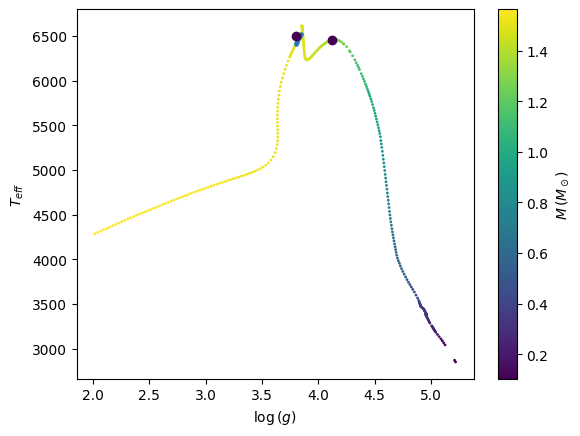

In [29]:
# define and sample priors for teff and log(g)
# this is purely for this notebook and should not be implemented into uberMS
# teff_prior = dist.Uniform(low=min(10**data['log_Teff']), high=max(10**data['log_Teff']))
# sample_Teff_a = teff_prior.sample(random.PRNGKey(2))


# logga_prior = dist.Uniform(low=min(data['log_g']), high=max(data['log_g']))
# sample_logg_a = logga_prior.sample(random.PRNGKey(2))

# q_prior = dist.Uniform(low=1E-6, high=1.0)
# sample_q = q_prior.sample(random.PRNGKey(2))

# set samples manually
# sample_Teff_a = 4500
# sample_logg_a = 2.5
# sample_q = 0.65

sample_Teff_a = 6500
sample_logg_a = 3.8
sample_q = 0.9

# print the sample we took
print(sample_Teff_a, sample_logg_a, sample_q)

# define a tolerance to find the closest teff and logg
teff_tol = 100
logg_tol = 0.05
mb_tol = 0.05


# define a condition to find the indices of the closest teff and logg
cond_teff = jnp.abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol
cond_logg = jnp.abs(data['log_g'] - sample_logg_a) < logg_tol

idx_closest = jnp.array(jnp.where(cond_teff & cond_logg))[0]
closest_logg = data['log_g'][idx_closest]
closest_teff = 10**data['log_Teff'][idx_closest]

print(f"closest logg:\n{closest_logg}")
print(f"closest teff:\n{closest_teff}")

if ~(jnp.all(jnp.diff(idx_closest) == 1)):
    median_logg = jnp.median(closest_logg)
    # print(f"median closest logg: {median_logg}")
    idx_cts = jnp.where(data['log_g'][idx_closest] > median_logg)
    logg_cts = data['log_g'][idx_closest][idx_cts]
    teff_cts = 10**data['log_Teff'][idx_closest][idx_cts]


    # now do interpolation
    mass_a = jnp.interp(sample_Teff_a, teff_cts, data['initial_mass'][idx_closest][idx_cts])
    # print(f'closest masses: {data["initial_mass"][idx_closest][idx_cts]}')
    print(f"\n mass_a: {mass_a}")

    # find mass_b using mass_a and sample_q
    mass_b = mass_a * sample_q
    print(f"\n mass_b: {mass_b}")

    # get logg_b and teff_b
    # find closest mass to mass_b
    cond_mass_b = jnp.abs(data['initial_mass'] - mass_b) < mb_tol

    idx_closest_b = jnp.where(cond_mass_b)

    # the initial_mass column is sorted, so we do not need to check
    # for continuity of the indices
    logg_b = jnp.interp(mass_b, data['initial_mass'][idx_closest_b], data['log_g'][idx_closest_b])
    teff_b = jnp.interp(mass_b, data['initial_mass'][idx_closest_b], 10**data['log_Teff'][idx_closest_b])
    
    print("\n\n\n\n\n\n")
    print(logg_b, teff_b)
    print(data['log_g'][idx_closest_b], 10**data['log_Teff'][idx_closest_b])


    # closest_logg = data['log_g'][idx_closest]
    # closest_teff = 10**data['log_Teff'][idx_closest]




    # closest_mass_b = min(np.abs(data['initial_mass'] - mass_b))
    # print(closest_mass_b)
    # idx_closest_b = np.where(np.abs(data['initial_mass'] - mass_b) == closest_mass_b)
    # print(f"Teff_b: {10**data['log_Teff'][idx_closest_b]}")
    # print(f"logg_b: {data['log_g'][idx_closest_b]}")


    # plot
    fig, ax = plt.subplots()

    ax.scatter(data['log_g'], 10**data['log_Teff'], c=data['initial_mass'], label='isochrone', s=1)
    ax.scatter(logg_cts, teff_cts, s=5)

    # ax.set_xlim(3.7, sample_logg_a + 0.5)

    ax.scatter(sample_logg_a, sample_Teff_a, c=mass_a)

    ax.scatter(logg_b, teff_b, c=mass_b)

    ax.set_xlabel(r'$\log{(g)}$')
    ax.set_ylabel(r'$T_{eff}$')

    fig.colorbar(ax.collections[0], label=r'$M \, ({M_\odot})$')
    plt.show()

    
else:
    # 1d regular interpolation to get primary mass
    print(sample_Teff_a)
    print(jnp.shape(closest_teff))
    print(jnp.shape(data['initial_mass'][idx_closest]))
    mass_a = jnp.interp(sample_Teff_a, closest_teff, data['initial_mass'][idx_closest])
    print(f'closest masses: {data["initial_mass"][idx_closest]}')

    print(f"\n mass_a: {mass_a}")

    # find mass_b using mass_a and sample_q
    mass_b = mass_a * sample_q
    print(f"\n mass_b: {mass_b}")

    # get logg_b and teff_b
        # find closest mass to mass_b
    cond_mass_b = jnp.abs(data['initial_mass'] - mass_b) < mb_tol

    idx_closest_b = jnp.where(cond_mass_b)

    # the initial_mass column is sorted, so we do not need to check
    # for continuity of the indices
    logg_b = jnp.interp(mass_b, data['initial_mass'][idx_closest_b], data['log_g'][idx_closest_b])
    teff_b = jnp.interp(mass_b, data['initial_mass'][idx_closest_b], 10**data['log_Teff'][idx_closest_b])


    # plot
    fig, ax = plt.subplots()

    ax.scatter(data['log_g'], 10**data['log_Teff'], c=data['initial_mass'], label='isochrone', s=1)
    ax.scatter(closest_logg, closest_teff, s=5)

    ax.scatter(sample_logg_a, sample_Teff_a, c=mass_a)
    ax.scatter(logg_b, teff_b, c=mass_b)

    ax.set_xlabel(r'$\log{(g)}$')
    ax.set_ylabel(r'$T_{eff}$')

    fig.colorbar(ax.collections[0], label=r'$M \, ({M_\odot})$')
    plt.show()

    
    # print(logg_b, teff_b)
    # print(data['log_g'][idx_closest], 10**data['log_Teff'][idx_closest])




# interp = jnp.interp(sample_teff, 10**data['log_Teff'], data['initial_mass'])
# print(f"\n{data['log_g'][idx_closest]}\n{10**data['log_Teff'][idx_closest]}")

In [337]:
np.where((data['initial_mass'] == sorted(data['initial_mass'])) == False)

(array([], dtype=int64),)

In [314]:
if np.any(10**data['log_Teff'] == 6500):
    print("yes")
else:
    print("no")

no


In [ ]:
print('Closest logg:')
print(data['log_g'][idx_closest])

median_test = np.median(data['log_g'][idx_closest])
print(f'\nlogg median: {median_test}\n')

print(np.where(data['log_g'][idx_closest] > median_test))
print('Closest logg < median:')
print(data['log_g'][idx_closest][np.where(data['log_g'][idx_closest] < median_test)])

Closest logg:
      log_g       
------------------
 4.573512675692805
 4.568963101580793
 4.564374812131633
 4.560251123595951
4.5562167255013835
  3.63827600152586
 3.634837556165945
3.6284685443547584
3.6178449186100434

logg median: 4.5562167255013835

(array([5, 6, 7, 8]),)
Closest logg < median:
      log_g       
------------------
  3.63827600152586
 3.634837556165945
3.6284685443547584
3.6178449186100434


In [ ]:
# cond_logg = np.abs(data['log_g'] - sample_logg_a) < logg_tol

# pass the conditions to the isochrone
closest_teff = 10**data['log_Teff'][cond_teff & cond_logg]
closest_logg = data['log_g'][cond_teff & cond_logg]
print(closest_teff, closest_logg)


fig, ax = plt.subplots()
ax.scatter(data['log_g'], 10**data['log_Teff'], c=data['initial_mass'], s=1)
ax.scatter(closest_logg, closest_teff, c='r', s=25, label='Closest')
ax.scatter(sample_logg_a, sample_Teff_a, c='k', s=25, label='Sample')

ax.legend()
plt.show()
# closest_logg = data['log_g'][np.abs(data['log_g'] - sample_logg_a) < logg_tol]

# (closest_teff, closest_logg)


# np.abs(10**data['log_Teff'] - sample_Teff_a < teff_tol)

In [144]:
a = np.array([0,4,2,6,3])
np.where(a>2), a[np.where(a>2)]
a = np.delete(a, 3)
a
# smallest = np.pop(a[a>2]

array([0, 4, 2, 3])

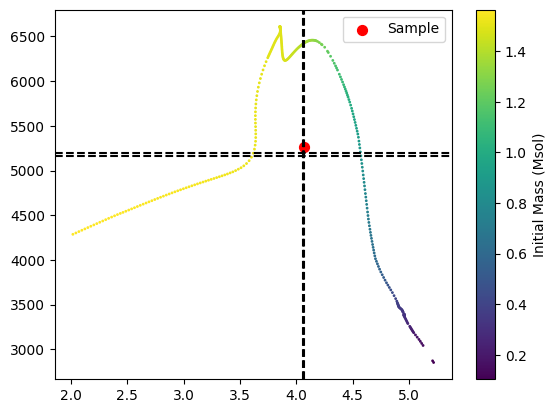

In [165]:
teff_tol = 100
logg_tol = 0.01

# np.abs(10**data['log_Teff'] - sample_Teff_a < teff_tol)

closest_teff = 10**data['log_Teff'][np.abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol]
closest_logg = data['log_g'][np.abs(data['log_g'] - sample_logg_a) < logg_tol]

(closest_teff, closest_logg)


fig, ax = plt.subplots()
ax.scatter(data['log_g'], 10**data['log_Teff'], c=data['initial_mass'], s=1)
ax.scatter(sample_logg_a, sample_Teff_a, c='red', s=50, label='Sample')
ax.axhline(sorted(closest_teff)[0], c='black', ls='--')
ax.axhline(sorted(closest_teff)[1], c='black', ls='--')

ax.axvline(sorted(closest_logg)[0], c='black', ls='--')
ax.axvline(sorted(closest_logg)[1], c='black', ls='--')
#ax.scatter(min(closest_logg), min(closest_teff), c='blue', s=50, label='Closest')

ax.legend()
fig.colorbar(ax.collections[0], label='Initial Mass (Msol)')
# ax.set_xlim(4.0, 4.5)

# plt.plot(closest_logg, closest_teff[:len(closest_logg)])
# good = abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol
# 10**data['log_Teff'][good]

In [74]:
# find closest two points in MIST isochrone to our sampled Teff and logg
teff_tol = 0.01
logg_tol = 0.01
closest_teff = min(abs(10**data['log_Teff'] - sample_Teff_a))
closest_logg = min(abs(data['log_g'] - sample_logg_a))
(closest_teff, closest_logg)


# 10**data['log_Teff'][abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol]

# data['log_Teff'][(abs(10**data['log_Teff'] - sample_Teff_a) < teff_tol)]

(Array(8.731934, dtype=float32), Array(0.00210285, dtype=float32))

In [92]:
10**data['log_Teff']

2852.90475694454
2871.426772679346
3043.250270866061
3065.8589579837094
3088.979471101631
3110.692582312181
3135.6645730593646
3160.754584925618
3185.587810805356
3196.95550543449
3207.466642744423


In [90]:
np.partition(10**data['log_g'], 2) == sorted(10**data['log_g'])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [4]:
interp = LinearNDInterpolator(
    list(zip(data['log_Teff'], data['log_g'])), data['initial_mass']
)

<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\o'
C:\Users\Jared\AppData\Local\Temp\ipykernel_15664\3261272432.py:4: SyntaxWarning: invalid escape sequence '\o'
  plt.colorbar(ax.collections[0], label='Mass (M$_\odot$)')


array(nan)

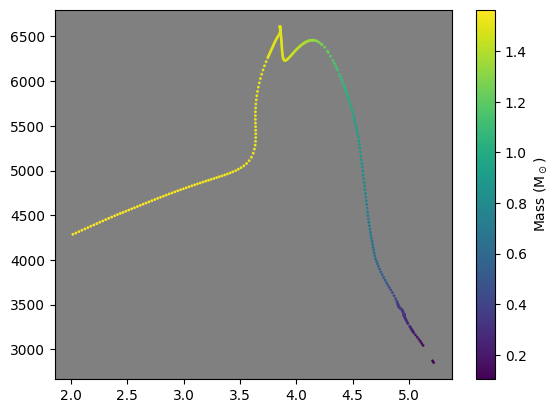

In [38]:
fig, ax = plt.subplots()
ax.scatter(data['log_g'], 10**data['log_Teff'], c=data['initial_mass'], s=1)
ax.set_facecolor('gray')
plt.colorbar(ax.collections[0], label='Mass (M$_\odot$)')
ax.scatter(2.1,5000,c=interp(2.1,5000))
interp(4.0, 6300)

In [ ]:
from scipy.interpolate import CloughTocher2DInterpolator

